# DATASCI W261: Machine Learning at Scale
## Assignment Week 2
Jackson Lane (jelane@berkeley.edu) <br>
W261-3 <br>

## HW2.0.  
##### What is a race condition in the context of parallel computation? Give an example.

A race condition is when the outcome of a certain program is determined by the order in which two or more parallel processess complete.  For example, consider the following pseudo code for a bank transaction:

    function withdraw(amount):
        if self.currentBalance > amount:
            self.currentBalance -= amount
            return amount
        else:
            raise "Not enough money error"

If a husband and wife both simultaneously try to withdraw $1000 from a shared checking account with a $1500 balance, then the outcome is uncertain.  If the husband's transaction completes before the wife's transaction starts, then the wife will get an error message for not haivng enough funds.  However, if the both transactins get past the "if statement" before one of the transactions deducts the amount, then both transactions will succeed and the account will end up with a negative balance.   

##### What is MapReduce? How does it differ from Hadoop?

MapReduce is a programming model developed by Google.  It frames data transformation and processing in terms of Maps and Reduces.  The Map steps in the model can always be done in parallel.  In between the Map and Reduce steps, there is a Shuffle step where the outputs of the Map steps are sorted and passed in order to the Reduce steps.

Apache Hadoop is a Java implementation of the MapReduce programming model.  It is not affiliated with Google and is just one of several implementations of the MapReduce programming model.  Hadoop also offers a file storage system called HDFS, which is separate from the MapReduce functionality and based on the Google File System model.

##### Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

Hadoop MapReduce is based on the MapReduce programming paradigm, which is in turn based off the "Map" and "Reduce" functions from functional programming, which is based on the idea of lambda calculus.  An example of functional programming is below  

In [136]:
def f(lamb):
    return lamb(1)

f(bool) # Applies the function bool to 1

True

 HDFS is based on the Google File System paradigm, which is in turn based off the distributed file system paradigm 

## HW2.1. Sort in Hadoop MapReduce
##### what happens if you have multiple reducers? Do you need additional steps? Explain.

Answer: If you have multiple reducers, then you will end up with multiple sorted lists at the end.  Each list will be sorted, but will only contain some of the elements of the input list.  To get back the entire input list sorted, you need a final reducer type job at the end to combine the outputs of all the other reducers with merge sort.

Write code to generate N  random records of the form < integer, “NA” >.

In [137]:
import numpy as np

#Utility function to generate N random records of the form < integer, "NA" >

def make_input(N=10000, name="random"):
    file = open(name,"w")
    #We want to generate numbers between a small range to test that the code handles duplicates 
    file.writelines(map(lambda i: "<" + str(i) + ",NA>\n", np.random.randint(1, 16,size=N)))
    file.close()
    return name
make_input()
!hadoop fs -mkdir -p .
!hdfs dfs -put -f random

16/06/17 02:08:41 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:08:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [138]:
%%writefile mappertop.py
#!/usr/bin/python
# mapper.py
# Author:Jackson Lane
# Description: mapper code for HW2.1

import sys

# Our input comes from STDIN (standard input)
for line in sys.stdin:
    print line[1:].strip()

Overwriting mappertop.py


Let N = 10,000. Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

In [139]:
%%writefile reducertop.py
#!/usr/bin/python 
# reducer.py
# Author:Jackson Lane
# Description: reducer code for HW2.1
import sys,Queue
from collections import deque
min_elements= []
max_elements = deque([])


for line in sys.stdin:
    value,_ = line.split(",")
    if len(min_elements) < 10 and value not in min_elements:
        min_elements.append(value)
    #Removed the duplicate check here
    #if value not in max_elements:
    if(len(max_elements) >= 10):
        max_elements.popleft()
    max_elements.append(value)

print "10 smallest numbers:", min_elements
print
print "10 biggest numbers:", list(max_elements)



Overwriting reducertop.py


Run the mapreduce job

In [140]:
!hdfs dfs -rm -r results/2.1
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options=-n \
-D mapreduce.output.key.field.separator="," \
-file mappertop.py \
-file reducertop.py \
-mapper "mappertop.py" \
-reducer "reducertop.py" \
-input random \
-output results/2.1

16/06/17 02:08:45 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:08:45 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.1
16/06/17 02:08:46 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:08:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mappertop.py, reducertop.py, /tmp/hadoop-unjar4130080841929025230/] [] /tmp/streamjob3824020512043058011.jar tmpDir=null
16/06/17 02:08:47 INFO client.RMProxy: Connecting to ResourceManager at /119.81.225.34:8032
16/06/17 02:08:47 INFO client.RMProxy: Connecting to ResourceManager at /119.81.225.34:8032
16/06/17 02:08:48 INFO mapred.FileInputFormat: Total input paths to process : 1
16/06/17 02:08:48 INFO mapreduce

In [141]:
!hdfs dfs -cat results/2.1/part-00000

16/06/17 02:09:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
10 smallest numbers: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']	
	
10 biggest numbers: ['15', '15', '15', '15', '15', '15', '15', '15', '15', '15']	


## HW2.2.  WORDCOUNT
Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

In [142]:
%%writefile mapperwordcount.py
#!/usr/bin/python 
# mapper.py
# Author: Jackson Lane

import sys
import re
findword = ""
if len(sys.argv) > 1:
    findword = sys.argv[1].lower()
for line in sys.stdin:
    line = line.strip()
    line = re.sub('\n','',line)
    words = re.split('\W+',line)
    for word in words:
        if len(word) > 0 and (len(findword) < 1 or findword == word.strip()):
            print word,1


Overwriting mapperwordcount.py


In [143]:
%%writefile reducerwordcount.py
#!/usr/bin/python 
# reducer.py
# Author: Jackson Lane
from __future__ import print_function
from operator import itemgetter
import sys

word = ""
count = 0

for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    newword, newcount = line.split()
    newcount = 1
    if (newword == word): count += newcount
    else:
        # We have finished with all instances of the current word.  
        # Print total count and move on to next word
        if (count > 0): print ("<",count,",", word ,">",sep='')
        word = newword
        count = newcount
if (count > 0): print ("<",count,",", word ,">", sep='')


Overwriting reducerwordcount.py


Run the mapreduce job

In [144]:
!hdfs dfs -rm -r results/2.2
!hdfs dfs -put -p -f enronemail_1h.txt
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapperwordcount.py \
-file reducerwordcount.py \
-mapper "mapperwordcount.py assistance" \
-reducer "reducerwordcount.py" \
-input enronemail_1h.txt \
-output results/2.2

16/06/17 02:09:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:09:07 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.2
16/06/17 02:09:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:09:10 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:09:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mapperwordcount.py, reducerwordcount.py, /tmp/hadoop-unjar8973235795763730311/] [] /tmp/streamjob4723042300583998361.jar tmpDir=null
16/06/17 02:09:11 INFO client.RMProxy: Connecting to ResourceManager at /119.81.225.34:8032
16/06/17 02:09:12 INFO client.RMProxy: Conne

In [145]:
!hdfs dfs -cat results/2.2/part-00000

16/06/17 02:09:29 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
<10,assistance>	


 
CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
           
       #NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

### HW2.2.1  Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)


<i>Here I am going to use the word count mapper and reducer to first produce the word counts for the enron e-mails in a temporay directory as a list of pairs.  Then I'm going feed this output into the the mapper from 2.1 and a slightly modified reducer from 2.1 to get the top occuring tokens from this list of pairs.  I need to modify the 2.1 reducer so it outputs only the top 10 elements instead of the top 10 and bottom 10 numbers. </i>

In [146]:
%%writefile reducertop.py
#!/usr/bin/python
# reducer.py
# Author:Jackson Lane
# Description: reducer code for HW2.2.1
import sys,Queue
from collections import deque
min_elements= []
max_elements = deque([])


for line in sys.stdin:
        value,word = line.split(",")
        #For some reason, hadoop puts a tab and a newline at the end of each word
        word = word[:-3]
        if len(min_elements) < 10:
            min_elements.append((value,word))
        if(len(max_elements) >= 10):
            max_elements.popleft()
        max_elements.append((value,word))

print "10 most common tokens:"
for i in range(len(max_elements)):
    print i+1,":", max_elements[-(i+1)]



Overwriting reducertop.py


Run the mapreduce job

In [147]:
!hdfs dfs -rm -r results/2.2
!hdfs dfs -rm -r temp

!hdfs dfs -put -p -f enronemail_1h.txt
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapperwordcount.py \
-file reducerwordcount.py \
-mapper "mapperwordcount.py" \
-reducer "reducerwordcount.py" \
-input enronemail_1h.txt \
-output temp

!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options=-n \
-D mapreduce.output.key.field.separator="," \
-file mappertop.py \
-file reducertop.py \
-mapper "mappertop.py" \
-reducer "reducertop.py" \
-input temp \
-output results/2.2


16/06/17 02:09:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:09:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.2
16/06/17 02:09:32 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:09:33 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted temp
16/06/17 02:09:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:09:36 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:09:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes wher

In [148]:
!hdfs dfs -cat results/2.2/part-00000

16/06/17 02:10:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
10 most common tokens:	
1 : ('1247', 'the')	
2 : ('964', 'to')	
3 : ('670', 'and')	
4 : ('566', 'of')	
5 : ('543', 'a')	
6 : ('444', 'you')	
7 : ('418', 'in')	
8 : ('394', 'your')	
9 : ('382', 'ect')	
10 : ('374', 'for')	


## HW2.3. Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. 

++Answer: As per the assignment, I'm going to have two pairs of mappers and reducers.  The first map and reduce pair will take the enron e-mail data and output a naive bayes classification model.  This model will consist of the priors for spam and ham followed by the spam and ham conditional probabilities for each word in the e-mails.  

Each conditional probability will be computed as:

$$
P(c\mid w)=\frac{N_{cw}
}{N_c}
$$

Where $N_{cw}$ is the count of word w in all e-mails of class c and $N_c$ is the count of all words in all e-mails of class c.

The second map and reduce pair will read in the model produced earlier and use it to classify a list of e-mails.  For this assignment, we are using the enron e-mails for both training and classification.  The posterior probability for each e-mail is computed as follows:

$$
\hat{P}(c\mid e) = log(prior_c) + \sum_{w^\prime \in e}{log(P(c\mid w))}
$$

Where $prior_c$ is the prior probability for class c and $\sum_{w^\prime \in e}{log(P(c\mid w))}$ is the sum of the logs of the conditional probabilities of class c given each word in the e-mail e.  As we are not using smoothing, some of these conditional probabilities are going to be 0, which means that taking their log will result in an undefined number.  I will ignore these errors in this problem with a try except statement.

Ths mapper will output each word and it's corresponding e-mail ID and class.  If a list of words is given to the mapper, it will only emit words that appear in that list.

In [149]:
%%writefile mapper_train.py
#!/usr/bin/python
# mapper_train.py
# Author: Jackson Lane
# Description: mapper code to train e-mail classification model
# Used for 2.3, 2.4, 2.5
import sys
import re

# get list of user specified words
findwords = []
if len(sys.argv) > 1:
    findwords = re.split(" ",sys.argv[1].lower())
for line in sys.stdin:  
    fields=line.split('\t') #parse line into separate fields
    #There is some malformed data here.  Going to ignore
    if len(fields) == 4:
        line = re.sub('\n','',line)
        [email,spam,subject,content] = fields           
        data = content.lower() + subject.lower()
        words = re.split('\W+',data)
        for word in words:
            #This flag indicates to the reducer that a given word is in the user specified word list
            #This field is not used for this problem
            if word in findwords or len(findwords) == 0:
                flag=1
            else: flag =0
            print [email,spam,word,flag]

Overwriting mapper_train.py


This reducer will calculate the prior and conditional probabilities for each word for the two classes of e-mail.  First it will total how many times each word appears in each class and how many times e-mails are of each class.  Then it will use this information to compute the prior probabilities for the classes and the conditional probabilities for each word.  It will print this information to a file for later usage.

In [150]:
%%writefile reducer_train.py
#!/usr/bin/python
# reducer_train.py
# Author: Jackson Lane
# Description: reducer code to train e-mail classification model
# Slightly modified to also record error rate and posterior probabilities

from __future__ import division #Python 3-style division syntax is much cleaner
import sys
from math import log

words={}
emails={}
spam_email_count=0 #number of spam emails
ham_email_count=0 #number of ham emails
spam_word_count=0 #number of words in spam emails
ham_word_count=0 #number of words in ham emails
for line in sys.stdin:

            #parse the incoming line
            line=eval(line)
            email=line[0]
            spam=int(line[1])
            word=line[2]
            flag=int(line[3])
            if spam==1:
                words.setdefault(word,{'ham_count':0,'spam_count':0})["spam_count"]+=1

                spam_word_count+=1
            else: 
                words.setdefault(word,{'ham_count':0,'spam_count':0})["ham_count"]+=1

                ham_word_count+=1
            #store email data 
            if(email not in emails.keys()):
                if spam==1:
                    spam_email_count+=1
                else: 
                    ham_email_count+=1
                emails[email] = {'spam':spam,'word_count':0,'words':[]}
            emails[email]['words'].append(word)
            emails[email]['word_count']+=1
#Calculate priors
prior_spam=spam_email_count/len(emails)
prior_ham=ham_email_count / len(emails)
print prior_spam
print prior_ham
for word,freq in words.iteritems():
    #emit word, conditional prob spam, conditional prob ham
    print(word,(freq['spam_count'])/spam_word_count,(freq['ham_count'])/ham_word_count)



Overwriting reducer_train.py


<i>This mapper reads the probability information generated by the training mapper and reducer and uses that information to find the posterior probabilities and perform Naive Bayes classification on a corpus of e-mails.  This mapper actually performs the functions of both a mapper and a reducer.  Like the training mapper, this classification mapper first breaks up the input e-mails into words.  But this classification mappper also then sums up the logs of the prior and conditional probabilities for each word to get the log posterior probabilities for each e-mail, sort of like how the training reducer summed up the counts of each word to get the priors and conditionals.  This mapper then classifies each e-mail based on whether the log of the spam posterior is higher than the log of the ham posterior and then emits its guesses to the reducer. 

Ideally, this mapper should multiply the conditionals and priors rather than take the sum the logs of the conditionals and priors.  But multiplying probabilities together quickly leads to memory underflow, so most implementations of Naive Bayes find the logs of the posteriors to avoid underflow.  Unfortunately, this leads to another issue because because the mathematical log of 0 is undefined.  So to accomodate instances where a posterior probabiltiy is 0, I've added in a modified version of the log function called "logSafe" that returns negative infinity for log(0).  </i>


In [151]:
%%writefile mapper_class.py
#!/usr/bin/python
# mapper_class.py
# Author: Jackson Lane
# Description: mapper code to classify e-mails
# Used for 2.3, 2.4, 2.5

from __future__ import division #Python 3-style division syntax is much cleaner
import sys,re, string, subprocess
from math import log

posts={}
spam_ignored_probabilities = 0 #number of spam posterior probabilities that will be ignored because they are 0
ham_ignored_probabilities = 0 #number of ham posterior probabilities that will be ignored because they are 0
def logSafe(n):
    if (n==0): return float("-inf")
    return log(n)

with open ("localmodel", "r") as model:

    prior_spam = float((model.readline())[:-2])
    prior_ham =float((model.readline())[:-2])
    for line in model.readlines():  
        line = line[:-2]
        word, p0, p1 = line.split()
        #Why does Hadoop keep on appending weird tabs and apostrophes to my words?  Cleaning them up here
        word=word[2:-2]
        posts[str(word)] = [float(p0[:-1]), float(p1[:-1])]



accuracy =0

for line in sys.stdin:
    line = re.sub('\n','',line)
    fields=line.split('\t') #parse line into separate fields
    #There is some malformed data here.  Going to ignore
    if len(fields) != 4: continue
    #Read off fields from model
    [email,spam,subject,content] = fields           
    data = content.lower() + subject.lower()
    p_spam=log(prior_spam)
    p_ham=log(prior_ham)
    words = re.split('\W+',data)
    for word in words:

        if word in posts:
#Since there are so many words, the posteriors are going to be really low.  
# So we need to use log to compute the posteriors.  Otherwise, we'll get underflow errors
            log_spam = 0
            log_ham = 0
            try:
                log_spam=logSafe((posts[word][0]))
                log_ham=logSafe((posts[word][1]))
                spam_ignored_probabilities += int(posts[word][0] ==0)
                ham_ignored_probabilities += int(posts[word][1] ==0)
            except ValueError:
                #A value error means one of the conditional probabilities was zero
                #Update zero counts for each class
                sys.stderr.write("Zero word: " + word + " , Email: " + email)
                spam_ignored_probabilities += int(posts[word][0] ==0)
                ham_ignored_probabilities += int(posts[word][1] ==0)
                #And ignore the probabilities for that word
                continue 
            p_spam+= log_spam
            p_ham+= log_ham
    if p_spam>p_ham:
        spam_pred=1
    else:
        spam_pred=0
    #I'd convert the posterior probabilities from the logs, but doing so would result in underflow
    print [email,spam,spam_pred,p_spam,p_ham,spam_ignored_probabilities,ham_ignored_probabilities]

Overwriting mapper_class.py


<i>This reducer computes the summary statistics for the Naive Bayes classifier implemented in the mapper.  It collects the  e-mails and the mapper's predcitions and then computes the mapper's accuracy and error rates. The reducer also emits the number of zero valued conditionals for e-mail so that they can be subsequently plotted on a histogram.  

In general, this reducer gets a relatively trivial task while the mapper actually performs the more significant reduction task of computing the posteriors.  I could have written it so that the reducer computes both reduction tasks instead of just one, but it's actually less network bandwidth for the mapper to computer the posteriors in memory.  
</i>

In [152]:
%%writefile reducer_class.py
#!/usr/bin/python
# reducer_class.py
# Author: Jackson Lane
# Description: reducer code to classify input e-mails
# Used for 2.3, 2.4, 2.5
import sys
import re

# get list of user specified words

spam_log_posterior_probabilities = [] #list of spam probabilities
ham_log_posterior_probabilities = [] #list of ham probabilities
accuracy = float(0)
N=float(0)
inf = float("inf")
for line in sys.stdin:  
    N+=1
    [email,spam,spam_pred,p_spam,p_ham, spam_ignored_probabilities, ham_ignored_probabilities]=eval(line[:-2])
    # We only want to report the real number posterior probabiltiies.  
    if (p_spam) <> float('-inf'):
        spam_log_posterior_probabilities.append(p_spam)
    if (p_ham) <> float('-inf'):
        ham_log_posterior_probabilities.append(p_ham)
    if (spam_pred == int(spam)): accuracy += 1

print "Accuracy:", accuracy / N
print "Error Rate:", 1- accuracy / N
print "Spam Zero Probabilities:", spam_ignored_probabilities
print "Ham Zero Probabilities:", ham_ignored_probabilities

#Just getting these in the output file so I can use them in the next question
print spam_log_posterior_probabilities
print ham_log_posterior_probabilities
  

Overwriting reducer_class.py


Run the mapreduce job

In [153]:
# clean up HDFS
!hdfs dfs -rm -r model
!hdfs dfs -rm -r results/2.3
# Run training job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_train.py \
-file reducer_train.py \
-mapper mapper_train.py \
-reducer reducer_train.py \
-input enronemail_1h.txt \
-output model
# Write model to disk (I know it's inefficient)
!hdfs dfs -cat model/part-00000 > localmodel
# Run classifying job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_class.py \
-file reducer_class.py \
-file localmodel \
-mapper mapper_class.py \
-reducer reducer_class.py \
-input enronemail_1h.txt \
-output results/2.3

16/06/17 02:10:14 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:10:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted model
16/06/17 02:10:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:10:16 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.3
16/06/17 02:10:17 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:10:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mapper_train.py, reducer_train.py, /tmp/hadoop-unjar3938437252633526423/] [] /tmp/streamjob2376815843470769843.jar tmp

In [154]:
!hdfs dfs -cat results/2.3/part-00000

16/06/17 02:10:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Accuracy: 1.0	
Error Rate: 0.0	
Spam Zero Probabilities: 1382	
Ham Zero Probabilities: 2729	
[-612.8559937094012, -1307.4416639009723, -848.5784852317115, -860.8950534266429, -791.0906075866317, -906.9722351683938, -806.8957586451087, -195.68554954833047, -7708.387907566293, -393.5759242603781, -1156.883946423883, -1071.6055219925113, -1279.7202461937625, -1494.2515676827882, -906.9722351683938, -4468.470788641613, -1031.6222720904884, -5967.455368113394, -1300.5819138200618, -786.0601653145035, -3415.7200554466444, -55.124508274508, -2394.0703124567785, -3413.9795892718034, -16082.688918585636, -530.3293012765532, -692.2692988858073, -163.20675671971395, -28798.8069023851, -1528.479986603461, -3623.671865609137, -178.41360325388993, -829.6369878878875, -945.2189947549223, -1338.9805398407195, -945.2189947549223, -17008.53559289951, -807.01

Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the  posterior probabilities (i.e., Pr(Class|Doc)) for each class over the training set. Summarize what you see. 

Error Rate:  0.0	

Number of Spam Zero Probabilities:  1382	

Number of Ham Zero Probabilities:  2729	



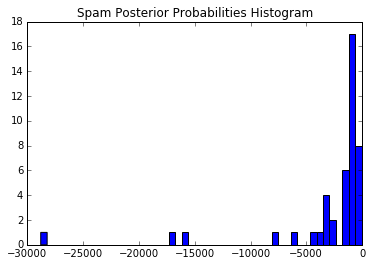

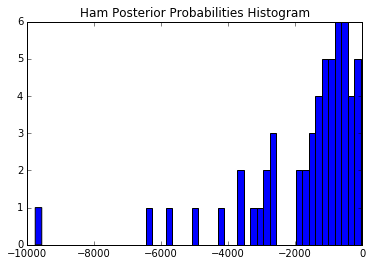

In [155]:
%matplotlib inline 
import numpy as np
import subprocess
import matplotlib
from matplotlib import pyplot as plt

#Code to print histogram of posterior probabilities

#read results of mapreduce job
cat = subprocess.Popen(["hadoop", "fs", "-cat", "results/2.3/part-00000"], stdout=subprocess.PIPE).stdout
spam_log_posterior_probabilities = []
ham_log_posterior_probabilities = []

#Function to parse a single line from the hdfs output file
def getandsplit():
    s = cat.readline()
    return s.split(":")

#Skip lines until we get to the line that reports Accuracy score
while getandsplit()[0] != "Accuracy":
    continue
    
#Save the error rate for the next problem
ErrorRateNoSmooth=getandsplit()[1]
print "Error Rate:", ErrorRateNoSmooth
print "Number of Spam Zero Probabilities:", getandsplit()[1]
print "Number of Ham Zero Probabilities:", getandsplit()[1]

#Parse the posterior probabilities from strings to lists of numbers.
#I wish there was an easier way to do this

spam_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]
ham_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]

plt.hist(spam_log_posterior_probabilities,bins=50)
plt.title("Spam Posterior Probabilities Histogram")
plt.show()

plt.hist(ham_log_posterior_probabilities, bins=50)
plt.title("Ham Posterior Probabilities Histogram")
plt.show()

Each zero probability is an instance of a word that appears in only one type of e-mail (either Spam e-mails or Ham e-mails but not both).  Hence the conditional probability of that word belonging to an e-mail of the other type is 0.  This leads to perfect accuracy, but probably hurts generalizability.  Even if it never happens in the training set, there are going to be instances in the real world where a ham e-mail contains the word "viagra."

## HW2.4 Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. 

We will use the same training mapper and classifer mapper and reducer as before, but we will modify the training reducer to compute conditional probabilities using +1 smoothing instead:

$$
P(c\mid w)=\frac{N_{cw}+1
}{N_c + N}
$$

Where $N_{cw}$ is the number of times the word w appears in class c, $N_c$ is the number of e-mails in the training set of class c, and N is the number of words 

In [156]:
#Keep same mappers and reducer_class as before

In [157]:
%%writefile reducer_train.py
#!/usr/bin/python
# reducer_train.py
# Author: Jackson Lane
# Description: reducer training code for HW2.4
# Slightly modified to also record error rate and posterior probabilities
# As in HW1.3, I'm going to ignore instances where a word does not appear in a class of e-mail
from __future__ import division #Python 3-style division syntax is much cleaner
import sys
from math import log

words={}
emails={}
spam_email_count=0 #number of spam emails
ham_email_count=0 #number of ham emails
spam_word_count=0 #number of words in spam emails
ham_word_count=0 #number of words in ham emails
for line in sys.stdin:

            #parse the incoming line
            line=eval(line)
            email=line[0]
            spam=int(line[1])
            word=line[2]
            flag=int(line[3])
            if spam==1:
                #+1 smoothing 
                words.setdefault(word,{'ham_count':1,'spam_count':1})["spam_count"]+=1

                spam_word_count+=1
            else: 
                #+1 smoothing 
                words.setdefault(word,{'ham_count':1,'spam_count':1})["ham_count"]+=1

                ham_word_count+=1
            #store email data 
            if(email not in emails.keys()):
                if spam==1:
                    spam_email_count+=1
                else: 
                    ham_email_count+=1
                emails[email] = {'spam':spam,'word_count':0,'words':[]}
            emails[email]['words'].append(word)
            emails[email]['word_count']+=1
# Compute total number of words in e-mail, subtract 2 for smoothing
vocabcount= sum(map(lambda v: v['ham_count'] + v['spam_count']-2,words.values()), 0)
#Calculate priors
prior_spam=spam_email_count/len(emails)
prior_ham=ham_email_count / len(emails)
print prior_spam
print prior_ham
for word,freq in words.iteritems():
    print(word,(freq['spam_count'])/(vocabcount+spam_word_count),(freq['ham_count'])/(vocabcount+ham_word_count))



Overwriting reducer_train.py


Run the mapreduce job

In [158]:
# clean up HDFS
!hdfs dfs -rm -r model
!hdfs dfs -rm -r results/2.4
# Run training job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_train.py \
-file reducer_train.py \
-mapper mapper_train.py \
-reducer reducer_train.py \
-input enronemail_1h.txt \
-output model
# Write model to disk (I know it's inefficient)
!hdfs dfs -cat model/part-00000 > localmodel
# Run classifying job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_class.py \
-file reducer_class.py \
-file localmodel \
-mapper mapper_class.py \
-reducer reducer_class.py \
-input enronemail_1h.txt \
-output results/2.4

16/06/17 02:11:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:11:01 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted model
16/06/17 02:11:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:11:03 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.4
16/06/17 02:11:04 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:11:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mapper_train.py, reducer_train.py, /tmp/hadoop-unjar3239288802760197769/] [] /tmp/streamjob7235591845756171446.jar tmp

In [159]:
!hdfs dfs -cat results/2.4/part-00000

16/06/17 02:11:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Accuracy: 0.99	
Error Rate: 0.01	
Spam Zero Probabilities: 0	
Ham Zero Probabilities: 0	
[-50.97762715443746, -41.22518962498689, -4741.26224742647, -4591.460537865014, -446.8580380415262, -1612.7822247663805, -3830.101005923457, -526.4575846150288, -683.4651855548785, -1444.7501129710686, -965.8218368601758, -536.4240036218639, -111.10720837331003, -1713.7323911784474, -1766.1045631361849, -952.0091848500035, -867.6512082353353, -1382.5087224848928, -1638.139353458615, -809.2272775735466, -1028.8803758703793, -881.1648181292431, -974.2559952049739, -1549.2275528244818, -507.80771372538135, -1124.3764728933372, -216.34575397879843, -8520.506709814616, -587.6295361202418, -11878.223475764815, -360.9350384498603, -433.01675427394343, -1257.0326175595187, -1181.017759369542, -1928.7186460572952, -872.3367918124769, -3788.6214392512006, -2048.2

Error Rate:  0.01	

Number of Spam Zero Probabilities:  0	

Number of Ham Zero Probabilities:  0	



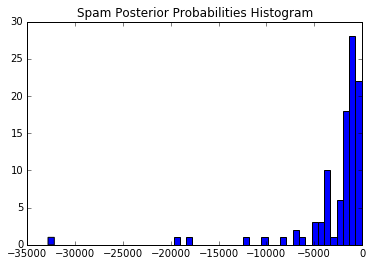

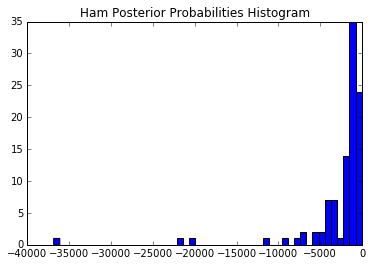

In [160]:
%matplotlib inline 
import numpy as np
import subprocess
import matplotlib
from matplotlib import pyplot as plt

#Code to print histogram of posterior probabilities

#read results of mapreduce job
cat = subprocess.Popen(["hadoop", "fs", "-cat", "results/2.4/part-00000"], stdout=subprocess.PIPE).stdout
spam_log_posterior_probabilities = []
ham_log_posterior_probabilities = []

#Function to parse a single line from the hdfs output file
def getandsplit():
    s = cat.readline()
    return s.split(":")

#Skip lines until we get to the line that reports Accuracy score
while getandsplit()[0] != "Accuracy":
    continue
    
#Save the error rate to compare against 2.3
ErrorRateSmooth = getandsplit()[1]

print "Error Rate:", ErrorRateSmooth
print "Number of Spam Zero Probabilities:", getandsplit()[1]
print "Number of Ham Zero Probabilities:", getandsplit()[1]

#Parse the posterior probabilities from strings to lists of numbers.
#I wish there was an easier way to do this
spam_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]
ham_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]

plt.hist(spam_log_posterior_probabilities,bins=50)
plt.title("Spam Posterior Probabilities Histogram")
plt.show()

plt.hist(ham_log_posterior_probabilities,bins=50)
plt.title("Ham Posterior Probabilities Histogram")
plt.show()

##### Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

In 2.3, we had many words that appeared exclusively in just one type of e-mail.  When we encountered those words in 2.3, we set the conditional probability of the other type of e-mail to 0.  For example, the word "viagra" would set the conditional probability of "ham" to 0, regardless of what other words were in the e-mail.  In 2.4, we used smoothing to in effect replace the zero probabilities with very low, but still positive, posterior probabilities.  This is why there are no zero probabilities in this model.  Since it's possible to take the log of an extremely low, but still positive number, we still somewhat get to take advantage of the words that appear exclusively in just one type of e-mail.  However, this smoothing also introduces noise into the data, and the accuracy of 2.4 is slightly lower than in 2.3 (but not by much).  However, 2.4 is probably more generalizable than 2.3. 

In [161]:
print "Error Rate 2.3:", ErrorRateNoSmooth
print "Error Rate 2.4:", ErrorRateSmooth

Error Rate 2.3:  0.0	

Error Rate 2.4:  0.01	



## HW2.5. Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. 

<i> Use the same mapper_train and reducer_class as 2.3.  Use the same reducer_train logic as in 2.4, except that have it ignore words with a count less than 3 (5 with +1 smoothing).  Use a different mapper_class that will recognize "ignored" probabilities instead of "zero" probabilities</i>

In [162]:
#Keep same mapper_train and reducer_class as before

In [163]:
%%writefile reducer_train.py
#!/usr/bin/python
# reducer_train.py
# Author: Jackson Lane
# Description: reducer training code for HW2.5
from __future__ import division #Python 3-style division syntax is much cleaner
import sys
from math import log

words={}
emails={}
spam_email_count=0 #number of spam emails
ham_email_count=0 #number of ham emails
spam_word_count=0 #number of words in spam emails
ham_word_count=0 #number of words in ham emails
for line in sys.stdin:

            #parse the incoming line
            line=eval(line)
            email=line[0]
            spam=int(line[1])
            word=line[2]
            flag=int(line[3])
            if spam==1:
                #+1 smoothing 
                words.setdefault(word,{'ham_count':1,'spam_count':1})["spam_count"]+=1

                spam_word_count+=1
            else: 
                #+1 smoothing 
                words.setdefault(word,{'ham_count':1,'spam_count':1})["ham_count"]+=1

                ham_word_count+=1
            #store email data 
            if(email not in emails.keys()):
                if spam==1:
                    spam_email_count+=1
                else: 
                    ham_email_count+=1
                emails[email] = {'spam':spam,'word_count':0,'words':[]}
            emails[email]['words'].append(word)
            emails[email]['word_count']+=1
#Calculate priors
prior_spam=spam_email_count/len(emails)
prior_ham=ham_email_count / len(emails)
print prior_spam
print prior_ham
for word,freq in words.iteritems():
    sys.stderr.write(word + ","+str(freq['spam_count'] + freq['ham_count']) + "\n")
    #Set p_spam and p_ham to zero if total count < 3
    #(< 5 when include smoothing) 
    if freq['spam_count'] + freq['ham_count'] < 5:
            print(word,0,0)
    else:
        print(word,float(freq['spam_count'])/spam_word_count,float(freq['ham_count'])/ham_word_count)



Overwriting reducer_train.py


In [164]:
%%writefile mapper_class.py
#!/usr/bin/python
# mapper_class.py
# Author: Jackson Lane
# Description: mapper code to classify e-mails
# Used for 2.5.  This one ignores 0 value conditional probabilities, rather than use them to set one posterior to 0

from __future__ import division #Python 3-style division syntax is much cleaner
import sys,re, string, subprocess
from math import log

posts={}
spam_ignored_probabilities = 0 #number of spam posterior probabilities that will be ignored because they are 0
ham_ignored_probabilities = 0 #number of ham posterior probabilities that will be ignored because they are 0


with open ("localmodel", "r") as model:

    prior_spam = float((model.readline())[:-2])
    prior_ham =float((model.readline())[:-2])
    for line in model.readlines():  
        line = line[:-2]
        word, p0, p1 = line.split()
        #Why does Hadoop keep on appending weird tabs and apostrophes to my words?  Cleaning them up here
        word=word[2:-2]
        posts[str(word)] = [float(p0[:-1]), float(p1[:-1])]



accuracy =0

for line in sys.stdin:
    line = re.sub('\n','',line)
    fields=line.split('\t') #parse line into separate fields
    #There is some malformed data here.  Going to ignore
    if len(fields) != 4: continue
    #Read off fields from model
    [email,spam,subject,content] = fields           
    data = content.lower() + subject.lower()
    p_spam=log(prior_spam)
    p_ham=log(prior_ham)
    words = re.split('\W+',data)
    for word in words:

        if word in posts:
#Since there are so many words, the posteriors are going to be really low.  
# So we need to use log to compute the posteriors.  Otherwise, we'll get underflow errors
            log_spam = 0
            log_ham = 0
            try:
                log_spam=log((posts[word][0]))
                log_ham=log((posts[word][1]))
            except ValueError:
                #A value error means one of the conditional probabilities was zero
                #Update zero counts for each class
                sys.stderr.write("Zero word: " + word + " , Email: " + email)
                spam_ignored_probabilities += int(posts[word][0] ==0)
                ham_ignored_probabilities += int(posts[word][1] ==0)
                #And ignore the probabilities for that word
                continue 
            p_spam+= log_spam
            p_ham+= log_ham
    if p_spam>p_ham:
        spam_pred=1
    else:
        spam_pred=0
    #I'd convert the posterior probabilities from the logs, but doing so would result in underflow
    print [email,spam,spam_pred,p_spam,p_ham,spam_ignored_probabilities,ham_ignored_probabilities]

Overwriting mapper_class.py


Run the mapreduce job

In [165]:
# clean up HDFS
!hdfs dfs -rm -r model
!hdfs dfs -rm -r results/2.5
# Run training job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_train.py \
-file reducer_train.py \
-mapper mapper_train.py \
-reducer reducer_train.py \
-input enronemail_1h.txt \
-output model
# Write model to disk (I know it's inefficient)
!hdfs dfs -cat model/part-00000 > localmodel
# Run classifying job
!hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-2*.jar \
-file mapper_class.py \
-file reducer_class.py \
-file localmodel \
-mapper mapper_class.py \
-reducer reducer_class.py \
-input enronemail_1h.txt \
-output results/2.5

16/06/17 02:11:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:11:49 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted model
16/06/17 02:11:50 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 02:11:50 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted results/2.5
16/06/17 02:11:51 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/06/17 02:11:51 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [mapper_train.py, reducer_train.py, /tmp/hadoop-unjar9129302413078561197/] [] /tmp/streamjob7385512017477128638.jar tmp

In [166]:
!hdfs dfs -cat results/2.5/part-00000

16/06/17 02:12:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Accuracy: 0.99	
Error Rate: 0.01	
Spam Zero Probabilities: 1619	
Ham Zero Probabilities: 1619	
[-26.90075438188021, -26.303672916073054, -3390.006273950761, -3567.186513179571, -357.74849311055, -1095.824657367988, -2843.0992857751135, -361.701921619377, -432.0202025557672, -804.3242536961257, -677.6714162655886, -411.38380911540753, -99.94657875094703, -1349.2276260668018, -1376.805846244258, -577.5579577332536, -433.1469676176849, -988.8812272179887, -1368.9035449170935, -571.5957127339924, -821.909884678915, -418.3835791044462, -547.4736633396731, -1258.2416005815032, -246.9176791859621, -713.3308365547988, -135.84487779665977, -5054.491564289689, -385.90468902900324, -8548.334535677344, -225.30532986431155, -243.1288659176856, -555.0858133282964, -634.7138880656022, -1519.175738960856, -533.226622607859, -3315.670620875743, -1474.057152

Error Rate: 0.01
Number of Spam Zero Probabilities:  1619	

Number of Ham Zero Probabilities:  1619	



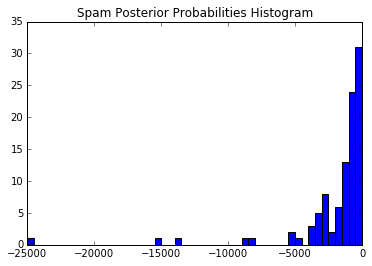

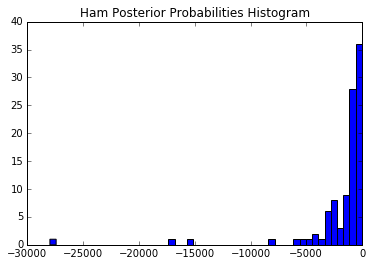

In [167]:
%matplotlib inline 
import numpy as np
import subprocess
import matplotlib
from matplotlib import pyplot as plt

#Code to print histogram of posterior probabilities

#read results of mapreduce job
cat = subprocess.Popen(["hadoop", "fs", "-cat", "results/2.5/part-00000"], stdout=subprocess.PIPE).stdout
spam_log_posterior_probabilities = []
ham_log_posterior_probabilities = []

#Function to parse a single line from the hdfs output file
def getandsplit():
    s = cat.readline()
    return s.split(":")

#Skip lines until we get to the line that reports Accuracy score
while getandsplit()[0] != "Accuracy":
    continue
    
#Save the error rate to compare against 2.3
ErrorRateSmoothAndMin = float(getandsplit()[1])

print "Error Rate:", ErrorRateSmoothAndMin
print "Number of Spam Zero Probabilities:", getandsplit()[1]
print "Number of Ham Zero Probabilities:", getandsplit()[1]

#Parse the posterior probabilities from strings to lists of numbers.
#I wish there was an easier way to do this
spam_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]
ham_log_posterior_probabilities = [float(x) for x in cat.readline().strip().strip('[').strip(']').split(',')]

plt.hist(spam_log_posterior_probabilities,bins=50)
plt.title("Spam Posterior Probabilities Histogram")
plt.show()

plt.hist(ham_log_posterior_probabilities,bins=50)
plt.title("Ham Posterior Probabilities Histogram")
plt.show()

##### How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:

In [168]:
print "Error Rate 2.3:", ErrorRateNoSmooth
print "Error Rate 2.4:", ErrorRateSmooth
print "Error Rate 2.5:", ErrorRateSmoothAndMin

Error Rate 2.3:  0.0	

Error Rate 2.4:  0.01	

Error Rate 2.5: 0.01


This model in 2.5 ended up with the same error rate as the model in 2.4, which is still higher though than the error rate in 2.3.  The model in 2.5 though ignored more words, so you would have expected it to have a slightly higher error rate, but probably be more generalizable.  Ignoring words that don't appear often shouldn't have too much of an effect though, as the words ignored by definition don't appear that often anyway.

## HW2.6 Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm
— Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error 
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
— Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [169]:
import re
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
    
data = np.array([])
labels = np.array([])
opened = open ("enronemail_1h.txt", "r") 
for line in opened.readlines():
    try:
        [email,spam,subject,content] = re.split("\t",line)            
        text = content.lower() + subject.lower()
        data=np.append(data,[text])
        labels=np.append(labels,[spam])
        
    except:
        #Just ignore data that gives an error.  This 
        continue
 
# Create features for train and dev data 
vectorizer = CountVectorizer()
trainingData = vectorizer.fit_transform(data)
#Data frame that I will use to show training errors
d = pd.DataFrame({"Model":[],"Training Error":[]})
classifier = BernoulliNB()
classifier.fit(trainingData, labels) 
#Training error is 1- accuracy score
d.loc[1]=["Bernoulli NB", 1-classifier.score(trainingData,labels)]
classifier = MultinomialNB()
classifier.fit(trainingData, labels) 
d.loc[2]=["Multinomial NB", 1-classifier.score(trainingData,labels)]
#I'm hardcoding the error rate I got from HW2.5
d.loc[3]=["HW2.5 Model", ErrorRateSmoothAndMin]

print d

            Model  Training Error
1    Bernoulli NB            0.16
2  Multinomial NB            0.00
3     HW2.5 Model            0.01


As in homework 1, the Bernoulli model has a much higher error rate than the Multinomial model or the model from the previous problem.  However, note that model from 2.5 is slightly worse than the Multinomial model, whereas the model from HW 1.5 also had a 0% training error.  This is because the model from 2.5 ignored the words that appeared less than 3 times in the corpus. The 2.5 model is otherwise identical to the model from HW 1.5. Despite not fitting the training data as well, the model from 2.5 is likley more generalizable than the sklearn Multinomial model or the model from 1.5, as it drops tokens that may have been included by mistake or as abberations.  